In [75]:
# 合并后的数据集
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("filter/merged_hpv.csv")
features = ['Chr', 'Start', 'SIFT_score', 'Polyphen2_HDIV_score', 'Polyphen2_HVAR_score','LRT_score', 'MutationTaster_score', 'MutationAssessor_score',  'FATHMM_score', 'RadialSVM_score', 'VEST3_score', 'CADD_phred', 'A_Ref', 'A_Alt']


x_train_all, x_valid_all, y_train, y_valid = train_test_split(df, df.iloc[:, 0], test_size=0.3, random_state=0)

# only need some features as input of classifier
x_train = x_train_all[features]
x_valid = x_valid_all[features]

E:\Envs\ml\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (46,59) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [71]:
print(df.shape)
print(x_train_all["True Label"].value_counts())
print(x_valid_all["True Label"].value_counts())
print(x_train_all.shape)
print(x_valid_all.shape)

(66577, 109)
1    24863
0    21740
Name: True Label, dtype: int64
1    10519
0     9455
Name: True Label, dtype: int64
(46603, 109)
(19974, 109)


In [77]:
# 调参后，分类器使用最优参数
from lightgbm.sklearn import LGBMClassifier

num_leaves = 48
# num_leaves = 29
n_estimators = 100
max_depth = 8
learning_rate = 0.05
early_stopping_rounds = 10
num_round = 700


# print(x_train.shape, x_valid.shape, x_test.shape, y_test.shape, y_valid.shape, y_test.shape)
# optimized_classifier = LGBMClassifier(boosting="gbdt", objective='binary', num_leaves=num_leaves, max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, is_unbalance=True, num_round=num_round, metrics='auc', max_bin=100)
optimized_classifier = LGBMClassifier(boosting="gbdt", num_leaves=100, max_depth=8, learning_rate=0.03, n_estimators=150, metrics='auc', min_child_samples=20, min_child_weight=0.001, bagging_fraction=0.6, feature_fraction=0.5, reg_alpha=0.08, reg_lambda=0.3, num_round=50, early_stopping_rounds=50)
# optimized_classifier.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], categorical_feature=["Chr", "Ref", "Alt", "A_Ref", "A_Alt"], early_stopping_rounds=early_stopping_rounds)
optimized_classifier.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], categorical_feature=["Chr", "A_Ref", "A_Alt"], early_stopping_rounds=early_stopping_rounds)
optimized_classifier

E:\Envs\ml\lib\site-packages\lightgbm\basic.py:1706: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['A_Alt', 'A_Ref', 'Chr']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
E:\Envs\ml\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
E:\Envs\ml\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] num_iterations is set=

LGBMClassifier(bagging_fraction=0.6, boosting='gbdt', early_stopping_rounds=50,
               feature_fraction=0.5, learning_rate=0.03, max_depth=8,
               metrics='auc', n_estimators=150, num_leaves=100, num_round=50,
               reg_alpha=0.08, reg_lambda=0.3)

In [74]:
optimized_classifier.feature_importances_

array([209, 635,   1,   0, 284, 196, 349, 279, 220, 384, 585, 368, 750,
       412,  69, 110])

In [78]:
# 在swissvar上比较不同分类器性能
import pandas as pd
import numpy as np

# features = ['Chr', 'Start', 'End', 'Ref', 'Alt', 'SIFT_score', 'Polyphen2_HDIV_score', 'Polyphen2_HVAR_score','LRT_score', 'MutationTaster_score', 'MutationAssessor_score',  'FATHMM_score', 'RadialSVM_score', 'VEST3_score', 'CADD_phred', 'A_Ref', 'A_Alt']
features = ['Chr', 'Start', 'SIFT_score', 'Polyphen2_HDIV_score', 'Polyphen2_HVAR_score','LRT_score', 'MutationTaster_score', 'MutationAssessor_score',  'FATHMM_score', 'RadialSVM_score', 'VEST3_score', 'CADD_phred', 'A_Ref', 'A_Alt']

labels = ["SIFT_Label", "Polyphen2_HDIV_Label", "Polyphen2_HVAR_Label", "LRT_Label", "MutationTaster_Label", "MutationAssessor_Label", "FATHMM_Label", "RadialSVM_Label", "VEST3_score", "CADD_phred"]

swissvar_test_all = pd.read_csv("filter/swissvar_with_labels.csv")
# swissvar_test_all = swissvar_test_all.dropna(subset=labels)
# swissvar_test_input = swissvar_test_all[features]

comparators = ['MCAP', 'REVEL', 'MVP_score','DANN_score', 'GERP++_RS']
swissvar_compare = swissvar_test_all.dropna(subset=comparators)
swissvar_input = swissvar_compare[features]

# 对分数做归一化
comparator_to_normalized = ["MCAP", 'GERP++_RS']

max_min_scaler = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))

for c in comparators:
    if c in comparator_to_normalized:
        swissvar_compare[c + "_normalized"] = swissvar_compare[[c]].apply(max_min_scaler)
    else:
        swissvar_compare[c + "_normalized"] = swissvar_compare[c]

E:\Envs\ml\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
E:\Envs\ml\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [72]:
print(swissvar_compare["True Label"].value_counts())
print(swissvar_compare.shape)

0    5004
1    4356
Name: True Label, dtype: int64
(9360, 122)


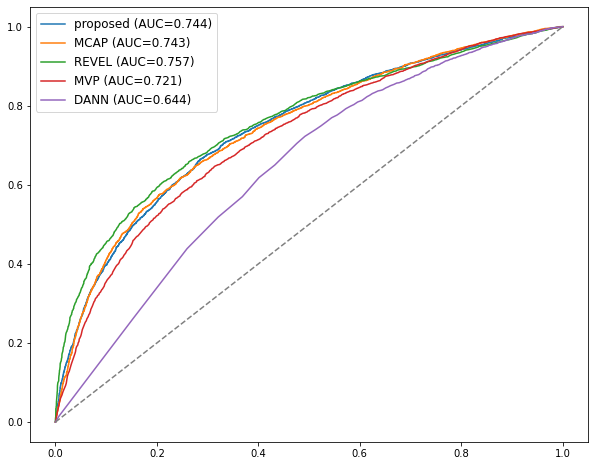

In [79]:
swissvar_output = optimized_classifier.predict_proba(swissvar_input)
swissvar_output = swissvar_output[:, 1]
swissvar_label = swissvar_compare["True Label"]

import sklearn.metrics as me
compare_classifiers = ["MCAP_normalized", "REVEL_normalized", "MVP_score_normalized", "DANN_score_normalized", "GERP++_RS_normalized"]
 
swissvar_probs = [swissvar_output, swissvar_compare["MCAP_normalized"], swissvar_compare["REVEL_normalized"], swissvar_compare["MVP_score_normalized"], swissvar_compare["DANN_score_normalized"]]

# 画roc曲线
import matplotlib.pyplot as plt

def draw_roc_curve(label, pred_probs, classifiers):
    fpr_tpr_aucs = []
    for pred_prob in pred_probs:
        assert(len(pred_prob)==len(label))
        fpr, tpr, thres= me.roc_curve(label, pred_prob)
        auc = me.auc(fpr, tpr)
        fpr_tpr_aucs.append([fpr, tpr, auc])
    fig, ax = plt.subplots(figsize=(10,8))
    for i in range(len(fpr_tpr_aucs)):
        ax.plot(fpr_tpr_aucs[i][0], fpr_tpr_aucs[i][1], label='{} (AUC={})'.format(classifiers[i], str(round(fpr_tpr_aucs[i][2], 3))))
    #绘制对角线
    ax.plot([0,1],[0,1],linestyle='--',color='grey')
    #调整字体大小
    plt.legend(fontsize=12)
    plt.savefig("result.png", dpi=1000, bbox_inches = 'tight')

classifers = ["proposed", "MCAP", "REVEL", "MVP", "DANN", "GERP++"]

draw_roc_curve(swissvar_label, swissvar_probs, classifers)

In [80]:
# 在exovar上比较不同分类器性能
import pandas as pd
import numpy as np

# features = ['Chr', 'Start', 'End', 'Ref', 'Alt', 'SIFT_score', 'Polyphen2_HDIV_score', 'Polyphen2_HVAR_score','LRT_score', 'MutationTaster_score', 'MutationAssessor_score',  'FATHMM_score', 'RadialSVM_score', 'VEST3_score', 'CADD_phred', 'A_Ref', 'A_Alt']
features = ['Chr', 'Start', 'SIFT_score', 'Polyphen2_HDIV_score', 'Polyphen2_HVAR_score','LRT_score', 'MutationTaster_score', 'MutationAssessor_score',  'FATHMM_score', 'RadialSVM_score', 'VEST3_score', 'CADD_phred', 'A_Ref', 'A_Alt']

labels = ["SIFT_Label", "Polyphen2_HDIV_Label", "Polyphen2_HVAR_Label", "LRT_Label", "MutationTaster_Label", "MutationAssessor_Label", "FATHMM_Label", "RadialSVM_Label", "VEST3_score", "CADD_phred"]

exovar_test_all = pd.read_csv("filter/ExoVarFiltered.hg19_multianno.csv")

comparators = ['MCAP', 'REVEL', 'MVP_score','DANN_score', 'GERP++_RS']
exovar_compare = exovar_test_all.dropna(subset=comparators)
exovar_input = exovar_compare[features]

# 对分数做归一化
comparator_to_normalized = ["MCAP", 'GERP++_RS']

max_min_scaler = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))

for c in comparators:
    if c in comparator_to_normalized:
        exovar_compare[c + "_normalized"] = exovar_compare[[c]].apply(max_min_scaler)
    else:
        exovar_compare[c + "_normalized"] = exovar_compare[c]

E:\Envs\ml\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (17,69) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
E:\Envs\ml\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
E:\Envs\ml\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


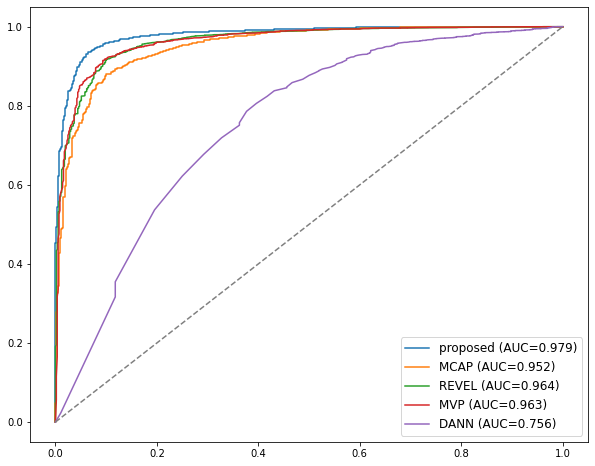

In [81]:
exovar_output = optimized_classifier.predict_proba(exovar_input)
exovar_output = exovar_output[:, 1]
exovar_label = exovar_compare["True Label"]

import sklearn.metrics as me
compare_classifiers = ["MCAP_normalized", "REVEL_normalized", "MVP_score_normalized", "DANN_score_normalized", "GERP++_RS_normalized"]
 
exovar_probs = [exovar_output, exovar_compare["MCAP_normalized"], exovar_compare["REVEL_normalized"], exovar_compare["MVP_score_normalized"], exovar_compare["DANN_score_normalized"]]

# 画roc曲线
import matplotlib.pyplot as plt

def draw_roc_curve(label, pred_probs, classifiers):
    fpr_tpr_aucs = []
    for pred_prob in pred_probs:
        assert(len(pred_prob)==len(label))
        fpr, tpr, thres= me.roc_curve(label, pred_prob)
        auc = me.auc(fpr, tpr)
        fpr_tpr_aucs.append([fpr, tpr, auc])
    fig, ax = plt.subplots(figsize=(10,8))
    for i in range(len(fpr_tpr_aucs)):
        ax.plot(fpr_tpr_aucs[i][0], fpr_tpr_aucs[i][1], label='{} (AUC={})'.format(classifiers[i], str(round(fpr_tpr_aucs[i][2], 3))))
    #绘制对角线
    ax.plot([0,1],[0,1],linestyle='--',color='grey')
    #调整字体大小
    plt.legend(fontsize=12)
    plt.savefig("result.png", dpi=1000, bbox_inches = 'tight')

classifers = ["proposed", "MCAP", "REVEL", "MVP", "DANN", "GERP++"]

draw_roc_curve(exovar_label, exovar_probs, classifers)

In [73]:
print(exovar_compare["True Label"].value_counts())
print(exovar_compare.shape)

1    4984
0     568
Name: True Label, dtype: int64
(5552, 114)
